In [58]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [80]:
metadata=pd.read_csv('infy.csv')
df=metadata.copy()

In [81]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-03-11,0.583984,0.781250,0.583984,0.732422,0.496775,172512000
1,1999-03-12,0.734375,0.761719,0.671875,0.728516,0.494125,39897600
2,1999-03-15,0.730469,0.730469,0.658203,0.662109,0.449084,12672000
3,1999-03-16,0.667969,0.691406,0.656250,0.656250,0.445110,9984000
4,1999-03-17,0.656250,0.699219,0.652344,0.660156,0.447759,15449600


In [82]:
df = df[['Date', 'Close']]
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)
df['Date']=df['Date'].apply(str_to_datetime)

In [84]:
df

,Date,Close
0,1999-03-11,0.732422
1,1999-03-12,0.728516
2,1999-03-15,0.662109
3,1999-03-16,0.656250
4,1999-03-17,0.660156
...,...,...
6089,2023-05-22,15.650000
6090,2023-05-23,15.530000
6091,2023-05-24,15.560000
6092,2023-05-25,15.660000


In [85]:
df.index=df.pop('Date')

In [86]:
df

,Close
Date,
1999-03-11,0.732422
1999-03-12,0.728516
1999-03-15,0.662109
1999-03-16,0.656250
1999-03-17,0.660156
...,...
2023-05-22,15.650000
2023-05-23,15.530000
2023-05-24,15.560000


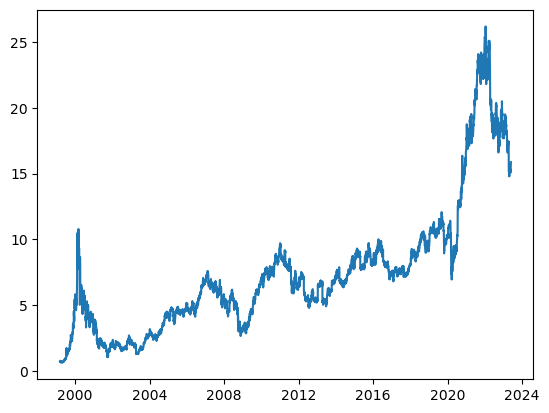

In [87]:
plt.plot(df.index,df['Close'])

In [119]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-27', 
                                '2023-05-26', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-27,18.709999,18.660000,18.459999,18.719999
1,2021-03-30,18.459999,18.719999,18.430000,18.799999
2,2021-03-31,18.719999,18.430000,18.799999,18.719999
3,2021-04-01,18.430000,18.799999,18.719999,19.010000
4,2021-04-05,18.799999,18.719999,19.010000,19.370001
...,...,...,...,...,...
541,2023-05-22,15.190000,15.150000,15.250000,15.650000
542,2023-05-23,15.150000,15.250000,15.650000,15.530000
543,2023-05-24,15.250000,15.650000,15.530000,15.560000
544,2023-05-25,15.650000,15.530000,15.560000,15.660000


In [120]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()
  dates=df_as_np[:,0]
  middle_matrix=df_as_np[:,1:-1]
  X=middle_matrix.reshape((len(dates),middle_matrix.shape[1],1))
  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)
dates, X, y = windowed_df_to_date_X_y(windowed_df)

In [121]:
dates.shape, X.shape, y.shape

((546,), (546, 3, 1), (546,))

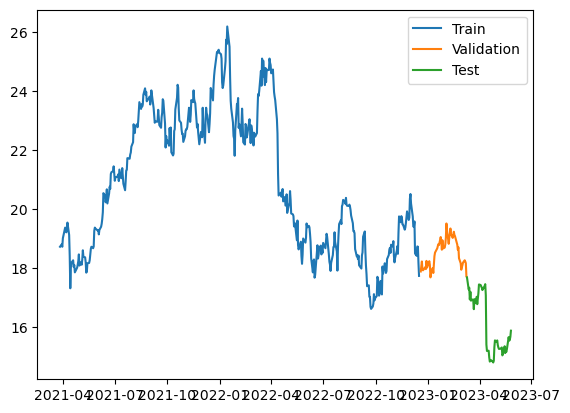

In [126]:
q_80=int(len(dates)*0.8)
q_90=int(len(dates)*0.9)

dates_train,X_train,y_train=dates[:q_80],X[:q_80],y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [123]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model=Sequential([
    layers.Dense(64,input_shape=(3,1)),        ## '64' is the number of units(neurons) and is necessary for dense layers
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

In [124]:
model.compile(loss='mse',optimizer=Adam(learning_rate=0.001),metrics=['mean_absolute_error'])

In [125]:
model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100)

Epoch 1/100
14/14 [==============================] - 2s 36ms/step - loss: 380.6843 - mean_absolute_error: 19.3502 - val_loss: 226.0324 - val_mean_absolute_error: 15.0264
Epoch 2/100
14/14 [==============================] - 0s 9ms/step - loss: 235.8484 - mean_absolute_error: 15.1212 - val_loss: 92.9819 - val_mean_absolute_error: 9.6309
Epoch 3/100
14/14 [==============================] - 0s 12ms/step - loss: 92.2727 - mean_absolute_error: 9.1579 - val_loss: 11.3168 - val_mean_absolute_error: 3.3294
Epoch 4/100
14/14 [==============================] - 0s 9ms/step - loss: 16.4999 - mean_absolute_error: 3.3010 - val_loss: 7.1923 - val_mean_absolute_error: 2.6377
Epoch 5/100
14/14 [==============================] - 0s 8ms/step - loss: 7.8178 - mean_absolute_error: 2.4031 - val_loss: 13.4811 - val_mean_absolute_error: 3.6398
Epoch 6/100
14/14 [==============================] - 0s 7ms/step - loss: 5.9873 - mean_absolute_error: 2.1593 - val_loss: 4.2997 - val_mean_absolute_error: 2.0168
Epoch 

14/14 [==============================] - 0s 3ms/step


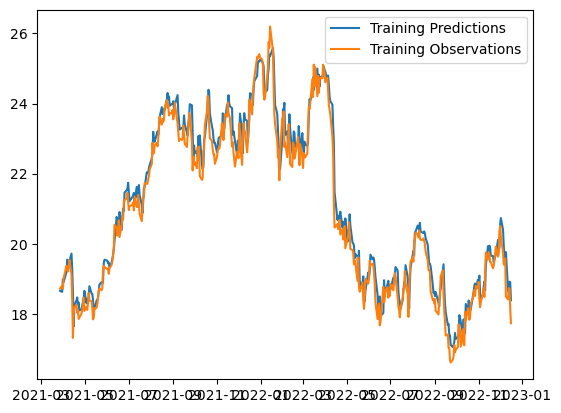

In [127]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 4ms/step


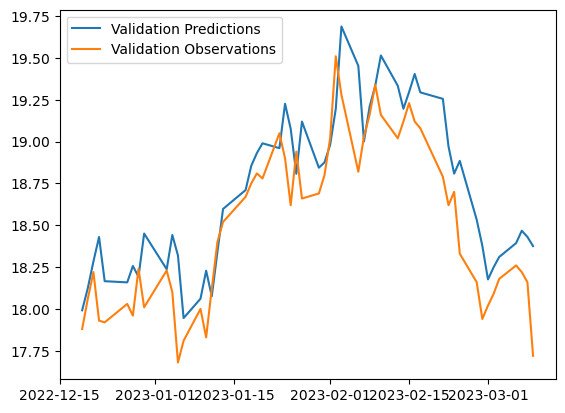

In [128]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 [==============================] - 0s 4ms/step


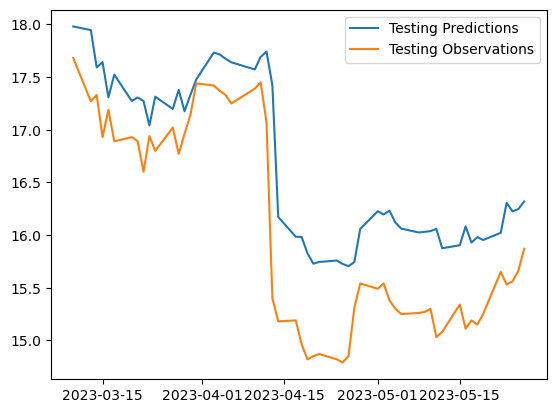

In [129]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

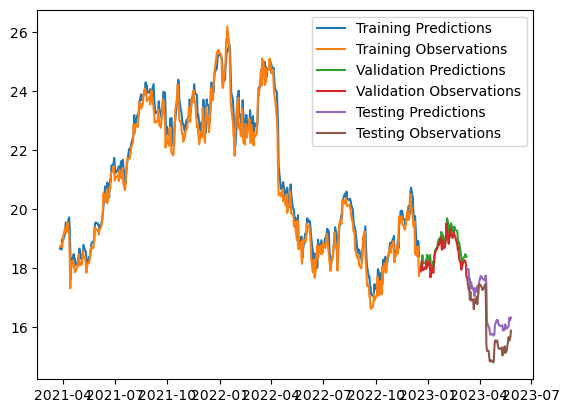

In [130]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])